In [4]:
import json, os
from functional import seq
from fn import _
import requests as r

# TODO: add creating here 

In [9]:
print(r.delete("http://localhost:9200/law_index6").json())

{'error': {'root_cause': [{'type': 'index_not_found_exception', 'reason': 'no such index', 'resource.type': 'index_or_alias', 'resource.id': 'law_index6', 'index_uuid': '_na_', 'index': 'law_index6'}], 'type': 'index_not_found_exception', 'reason': 'no such index', 'resource.type': 'index_or_alias', 'resource.id': 'law_index6', 'index_uuid': '_na_', 'index': 'law_index6'}, 'status': 404}


In [11]:
create_index_body = {
  "settings": {
    "analysis": {
      "analyzer": {
        "my_custom_analyzer": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": [
            "law_synonyms",
            "morfologik_stem",
            "lowercase"
          ]
        }
      },
      "filter": {
        "law_synonyms": {
          "type": "synonym",
          "synonyms": [
            "kpc  => kodeks postępowania cywilnego",
            "kpk => kodeks postępowania karnego",
            "kk => kodeks karny",
            "kc => kodeks cywilny"
            ]
        }
      }
    }
  },
  "mappings": {
    "_doc": {
      "properties": {
        "title": {
          "type": "text",
          "analyzer": "default",
          "search_analyzer": "default",
          "search_quote_analyzer": "default"
        },
        "content": {
          "type": "text",
          "term_vector": "with_positions_offsets_payloads",
          "analyzer": "my_custom_analyzer",
          "search_analyzer": "my_custom_analyzer",
          "search_quote_analyzer": "my_custom_analyzer"
        }
      }
    }
  }
}


create_resp = r.put("http://localhost:9200/law_index6",json=create_index_body)
print(create_resp.json())


{'acknowledged': True, 'shards_acknowledged': True, 'index': 'law_index6'}


In [12]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import os
es = Elasticsearch(retry_on_timeout=True)

actions = [{
    "_index": "law_index6",
    "_id": i,
    "_type": "_doc",
    "_source": {
        "content": open("../ustawy/" + file).read(),
        "filename": file
    }
} for i, file in enumerate(os.listdir("../ustawy"))]

helpers.bulk(es, actions)

(1180, [])

In [13]:
def get_termvectors(doc_id):
    data = {                                                                                      
      "fields" : ["content"],                                                                                                         
      "offsets" : True,                                                                                         
      "positions" : True,                                                                                                                                                                                                                                                          
      "term_statistics" : True,                                       
      "field_statistics" : True                                                                                                                                                                                                                                                    
    }   
    url = "http://localhost:9200/law_index6/_doc/{}/_termvectors".format(doc_id)
    response = r.post(url,json=data)
    return json.loads(response.content)


In [15]:
def frequency_extractor(term_dict):
    return term_dict['term_freq']

def body_to_freqs(body): #Sequence[str,int]
    return seq(body['term_vectors']['content']['terms'].items())\
        .filter(lambda x: x[0].isalpha())\
        .map(lambda x: (x[0],frequency_extractor(x[1])))

In [16]:
def get_freqs(doc_id): #Sequence[Term,Ocurrences]
    body = get_termvectors(doc_id)
    return body_to_freqs(body)

# Get docs from index 

In [17]:
def get_ids():
    match_all_query = {
      "query": {
        "match_all": {}
      },
        "size":1200,
      "_source": "_id"
    }

    resp = r.post("http://localhost:9200/law_index6/_search",json=match_all_query)
    hits = resp.json()['hits']['hits']
    return seq(hits).map(lambda x: x['_id'])

In [37]:
# frequency_list = get_ids()\
# .flat_map(lambda ajdi: get_freqs(ajdi))\
# .group_by(lambda x:x[0])\
# .map(lambda group: (
#     group[0],
#     seq(group[1]).map(lambda x:x[1]).sum()
# ))\
# .filter(lambda x:x[0].isalpha() and len(x[0])>=2)\
# .order_by(lambda x: -x[1])
# frequency_list.to_csv("frequency_list.out")
frequency_list = seq.csv("frequency_list.out").map(lambda x: (x[0],int(x[1])))

In [38]:
frequency_list

wiek,188681
ojciec,65253
ocean,65202
do,61002
artykuł,53912
usta,53705
na,50809
który,49562
on,49331
się,46522


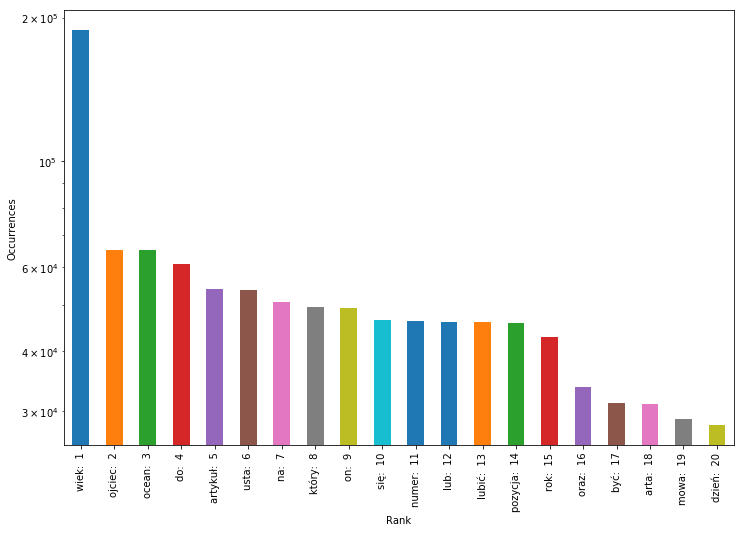

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plot_data = frequency_list.take(20)
freq_series = pd.Series(plot_data.map(lambda x:x[1]).to_list())

x_labels = plot_data.map(lambda x:x[0]).enumerate().map(lambda enum: enum[1] +":  "+ str(enum[0]+1)).to_list()

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
# ax.set_title('Rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Occurrences')
ax.set_yscale('log')
ax.set_xticklabels(x_labels)

rects = ax.patches

# Using polimorfologik 

In [29]:
# polish_dict = seq.csv("polimorfologik/polimorfologik-2.1.txt",delimiter=";")\
#     .flat_map(lambda x : (x[0].lower() ,x[1].lower()))\
#     .filter(lambda x: x.isalpha()).distinct()
# polish_dict.to_csv("polimorgologik.out")

In [ ]:
polish_dict = seq.csv("polimorfologik.out")

In [31]:
top30_non_in_dict = frequency_list.filter(lambda x: x[0] not in polish_dict).take(30)

In [32]:
top30_non_in_dict #todo - pooooor performance

KeyboardInterrupt: 